# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.
<hr>

# Описание данных

Данные находятся в файле /datasets/autos.csv.

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

### Установка копонентов

In [1]:
%%capture
!pip install phik
!pip install mlxtend
!pip install -U scikit-learn

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import timeit
import warnings

warnings.filterwarnings("ignore")  

#библиотеки для работы с графиками
import matplotlib.pyplot as plt 
from mlxtend.plotting import plot_decision_regions
from itertools import combinations

#класс для разделения данных на выборки
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV, 
    GridSearchCV
)

#модели
from sklearn.svm import SVC
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree

#метрики
from phik.report import plot_correlation_matrix
from phik import phik_matrix
from sklearn.metrics import(
    confusion_matrix, 
    accuracy_score,
    f1_score,
    fbeta_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    mean_squared_error
)

#классы подготовки данных
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    StandardScaler,
    MinMaxScaler, 
)

# класс для работы с пропусками
from sklearn.impute import SimpleImputer 

#класс для работы с пайплайнами
from sklearn.pipeline import Pipeline

### Указание констант

In [3]:
TEST_SIZE = 0.25
state = np.random.RandomState(12345)

## Подготовка данных 

In [4]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Копируем датасет, чтобы у нас был доступ к исходным данным

In [5]:
data_new = data

### Редактирование заголовков

Переведем заголовки под стандарты snake_case

In [6]:
data_new.columns = data_new.columns.str.lower()
data_new = data_new.rename(columns = {
    'datecrawled':'date_crawled',
    'vehicletype': 'vehicle_type',
    'registrationyear':'registration_year',
    'registrationmonth' : 'registration_month',
    'fueltype':'fuel_type',
    'datecreated':'date_created',
    'numberofpictures':'number_of_pictures',
    'postalcode':'postal_code',
    'lastseen':'last_seen'
})
data_new.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Изучение данных

Размерность датафрейма: (354369, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen   

,count,mean,std,min,25%,50%,75%,max
price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
registration_year,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
number_of_pictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postal_code,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


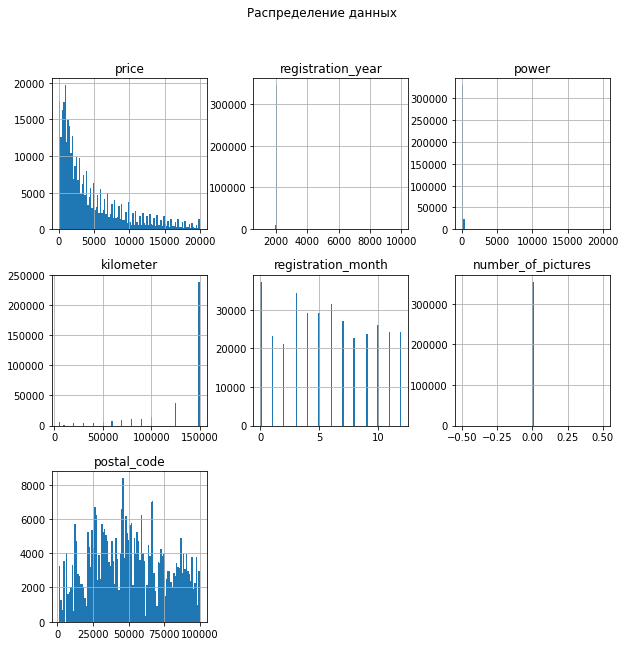

In [7]:
print('Размерность датафрейма:', data_new.shape, '\n')
data_new.info()
display(data_new.describe().T)

data_new.hist(figsize = (10, 10), bins = 100)
plt.suptitle('Распределение данных');

Из описания можно выделить следующие аномалии в данных: нулевая стоимость и мощность автомобиля, а также максимальное значение мощности, которое намного больше значения третьего квартиля, минимальный год регистрации автомобилей, равный 1000 году и нулевой месяц регистрации. Посмторим сколько таких записей.

Видны пропуски в столбцах:
- vehicle_type
- fuel_type
- repaired

С ними будем работать после обработки аномальных значений.
Несоответствие типа данных наблюдается у `date_crawled, date_created, last_seen`. Данные столбцы нужно перевести в тип datetime.

### Изменение типа данных

In [8]:
date_col = ['date_crawled', 'date_created', 'last_seen']

for i in date_col:
    data_new[i] = pd.to_datetime(data_new[i], format = '%Y-%m-%d %H:%M:%S')
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

### Поиск дубликатов

In [9]:
print(f'Количество явных дубликатов: {data_new.duplicated().sum()}')
print(f'Процент дубликатов от общего количества записей: {(data_new.duplicated().sum() / len(data_new)):.2%}')

Количество явных дубликатов: 4
Процент дубликатов от общего количества записей: 0.00%


In [10]:
data_new = data_new.drop_duplicates().reset_index(drop = True)
len(data)

354369

Неявные дубликаты будем искать в следующих столбцах: 

In [11]:
obj = data_new.select_dtypes(include = 'object').columns
obj

Index(['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'], dtype='object')

In [12]:
for i in obj:
    print(f'Неявные дубликаты в {i} \n', data_new[i].sort_values().unique(), '\n')

Неявные дубликаты в vehicle_type 
 ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan] 

Неявные дубликаты в gearbox 
 ['auto' 'manual' nan] 

Неявные дубликаты в model 
 ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace

Неявные дубликаты в столбце model - range_rover, rangerover

In [13]:
data_new['model'] = data_new['model'].replace('range_rover', 'rangerover')

### Исследовательский анализ данных

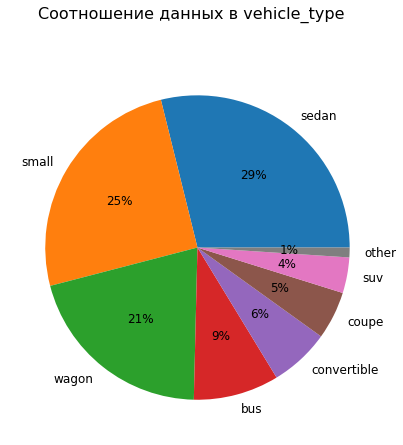

________________________________________________________________________________________________________________________


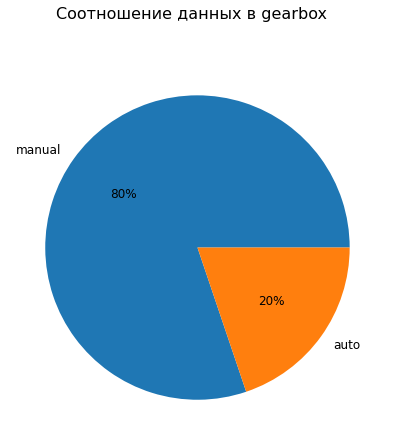

________________________________________________________________________________________________________________________


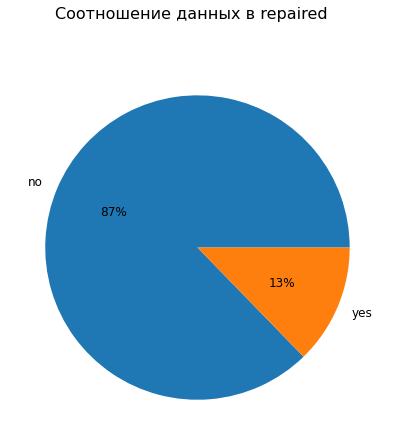

________________________________________________________________________________________________________________________


In [14]:
obj = obj.drop(['model', 'brand', 'fuel_type'])
for column in obj:
    data_new[column].value_counts().plot(
        kind = 'pie',
        figsize = (7, 7),
        autopct = '%0.f%%',
        fontsize = 12
    )
    plt.suptitle(f'Соотношение данных в {column}', fontsize = 16)
    plt.ylabel('')
    plt.show()
    
    print('_'*120)

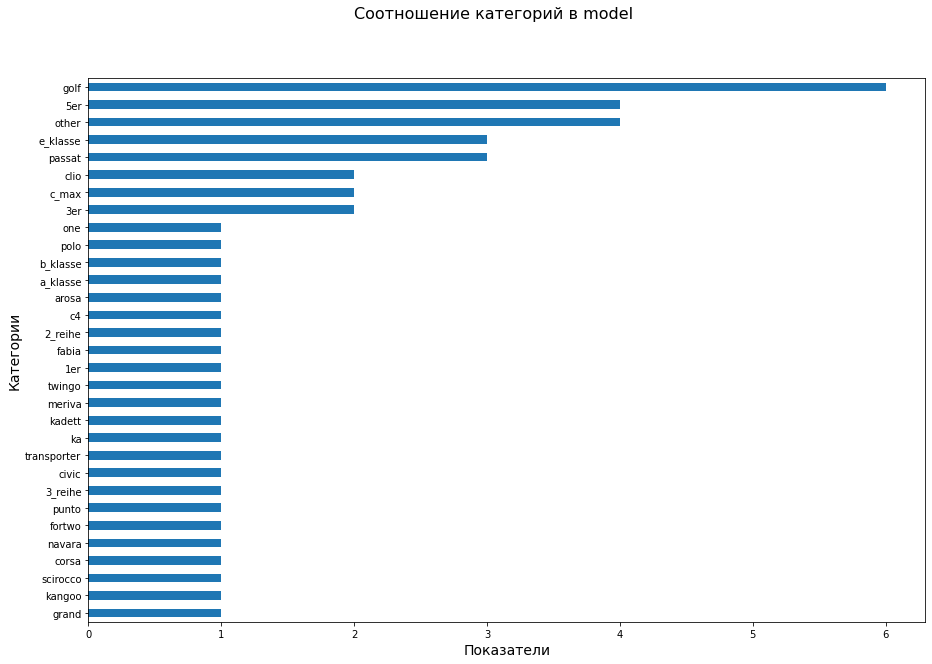

________________________________________________________________________________________________________________________


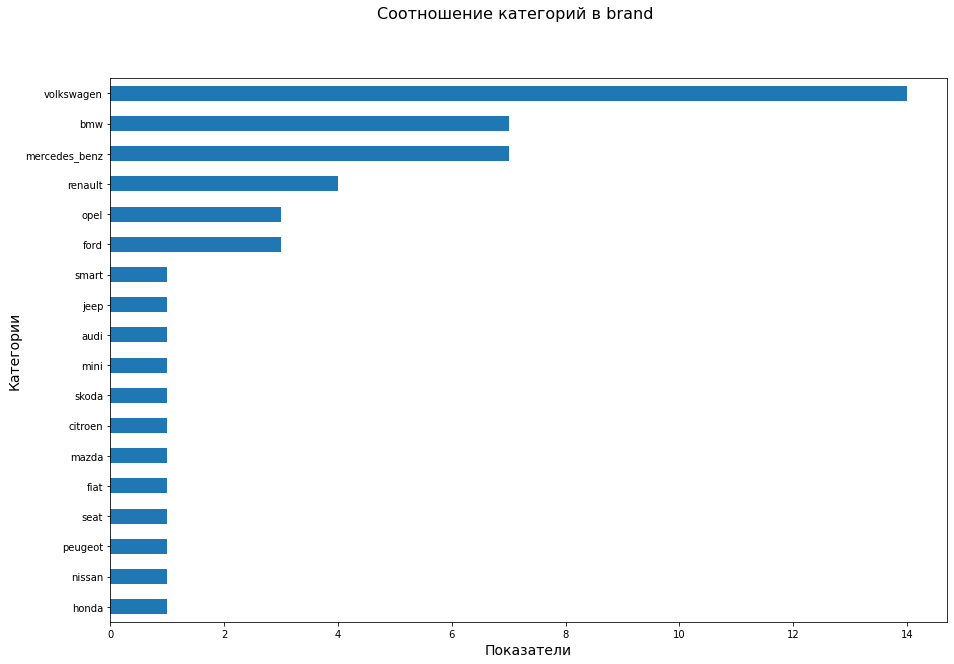

________________________________________________________________________________________________________________________


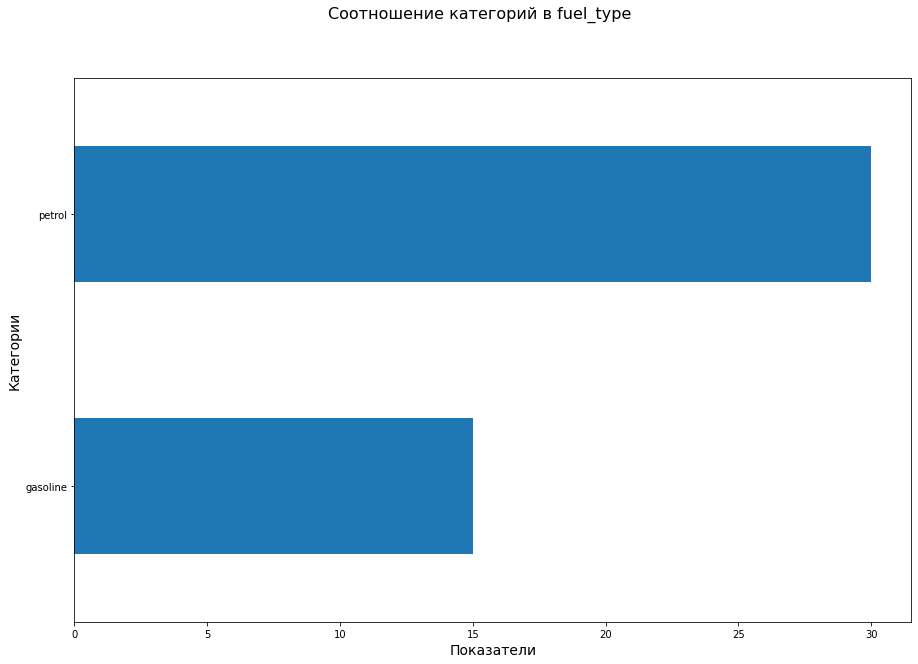

________________________________________________________________________________________________________________________


In [15]:
x = data_new[['model', 'brand', 'fuel_type']]

for column in x:
    data_new[column].head(50).value_counts().sort_values(ascending = True).plot(
        kind = 'barh',
        figsize = (15,10)
    )
    
    plt.suptitle(f'Соотношение категорий в {column}', fontsize = 16)
    plt.xlabel('Показатели', fontsize = 14)
    plt.ylabel('Категории', fontsize = 14)
    plt.show();
    
    print('_'*120)

- По типу автомобильного кузова по количетсву записей лидируют позиции `sedan, small, wagon`
- У большинства механическая коробка передачь
- Больше указано таких моделей автомобиля, как `golf, other, 5er`
- Для большинства автомобилей указаны следующие типы топлива - `petrol, gasoline
- Наибольшее количество автомобилей представлено у брендов `volkswagen, opel, bmv`
- Большинство машин не было в ремонте

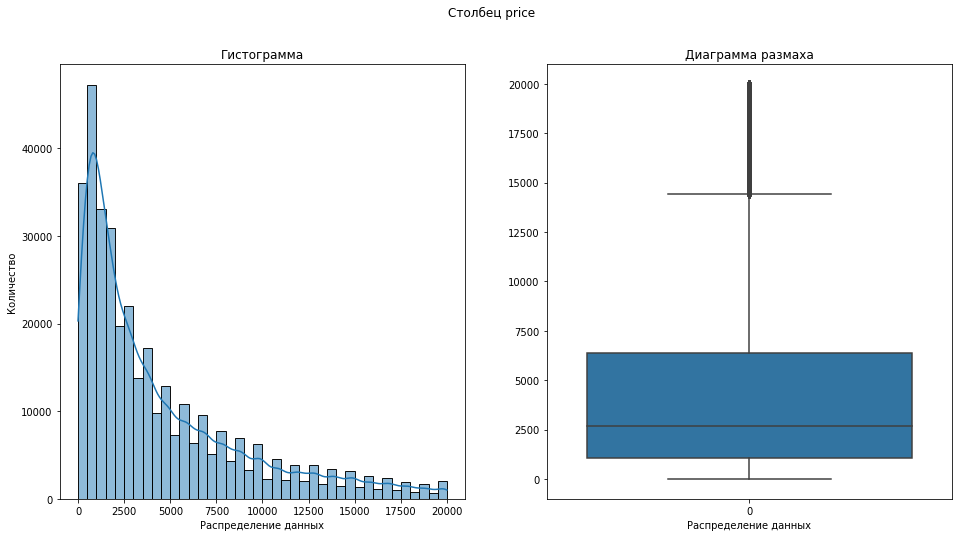

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

________________________________________________________________________________________________________________________


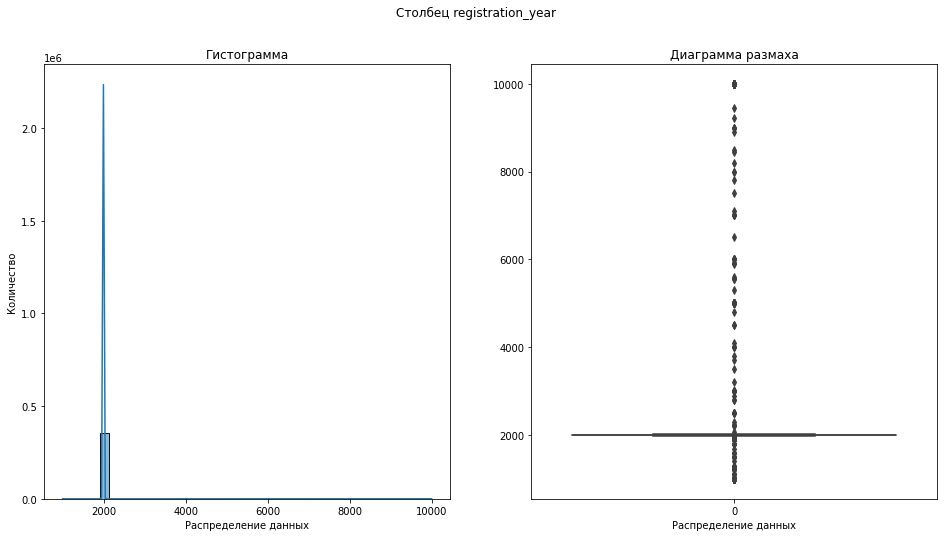

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

________________________________________________________________________________________________________________________


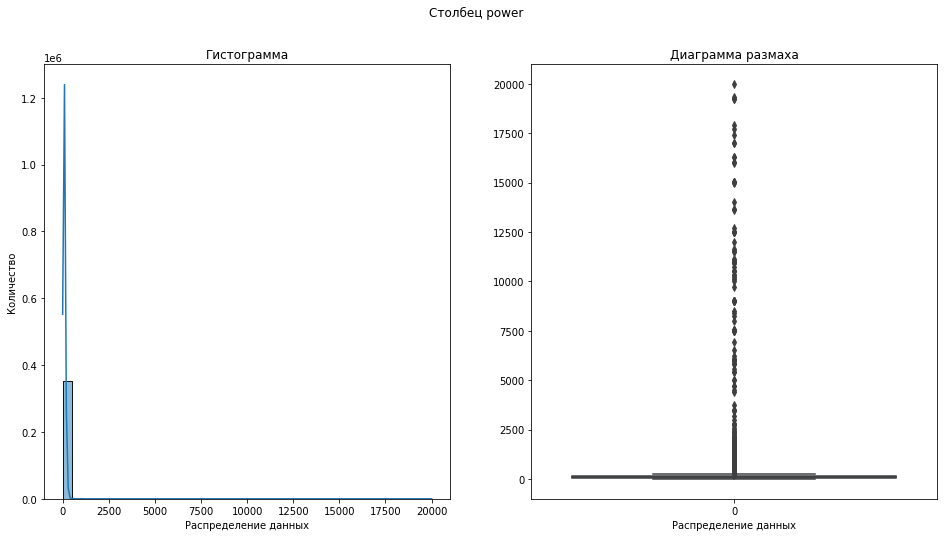

count    354365.000000
mean        110.093816
std         189.851330
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

________________________________________________________________________________________________________________________


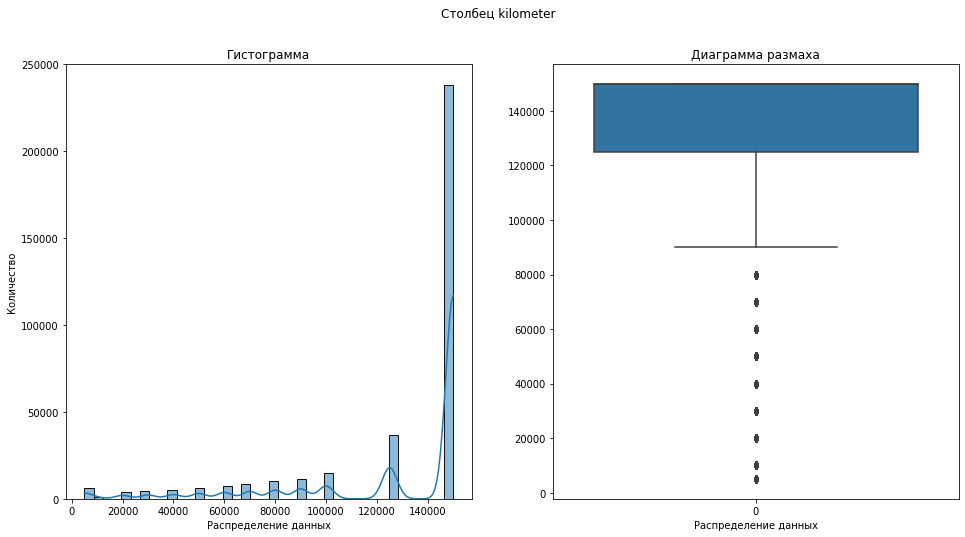

count    354365.000000
mean     128211.363989
std       37905.083858
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

________________________________________________________________________________________________________________________


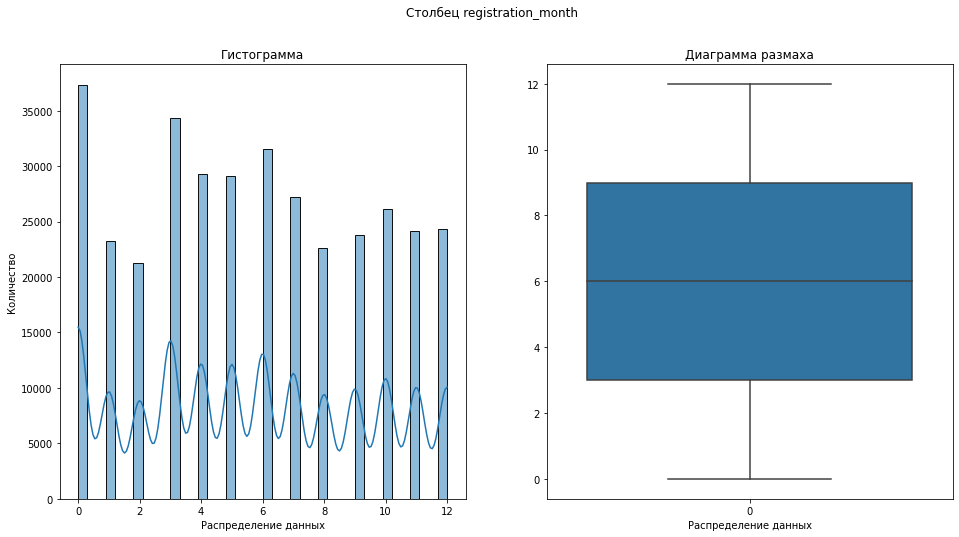

count    354365.000000
mean          5.714650
std           3.726432
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

________________________________________________________________________________________________________________________


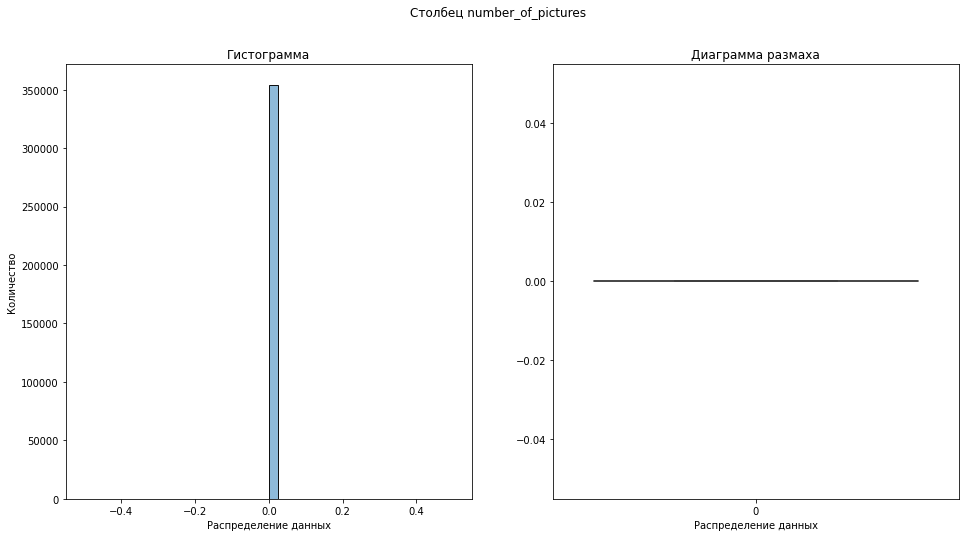

count    354365.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

________________________________________________________________________________________________________________________


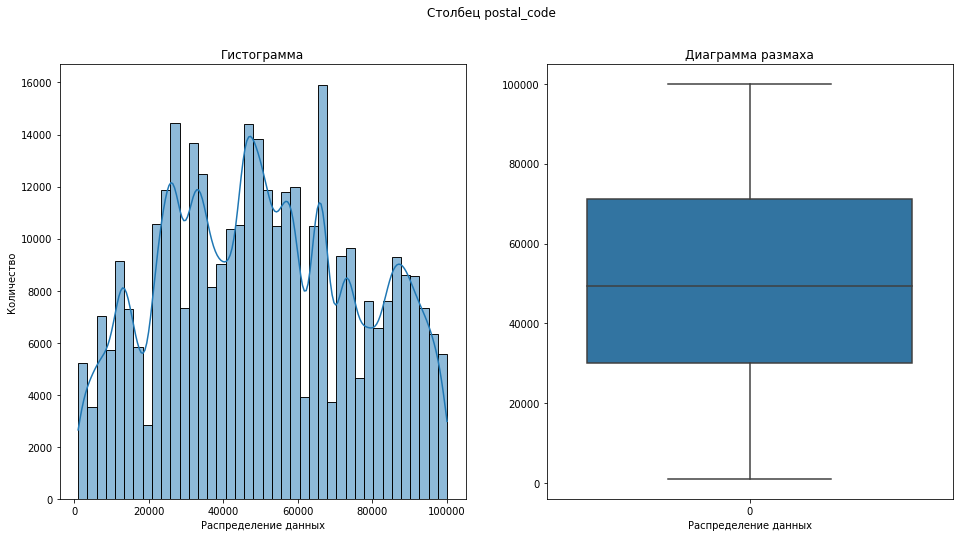

count    354365.000000
mean      50508.503800
std       25783.100078
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: postal_code, dtype: float64

________________________________________________________________________________________________________________________


In [16]:
num = data_new.select_dtypes(include = 'number').columns

for column in num:
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
    
    sns.histplot(data = data_new[column], ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel('Распределение данных')
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')

    sns.boxplot(data = data_new[column], ax=axs[1])
    axs[1].set_xlabel('Распределение данных')
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Столбец {column}')
    
    plt.show()
    
    display(data_new[column].describe())
    print('_'*120)

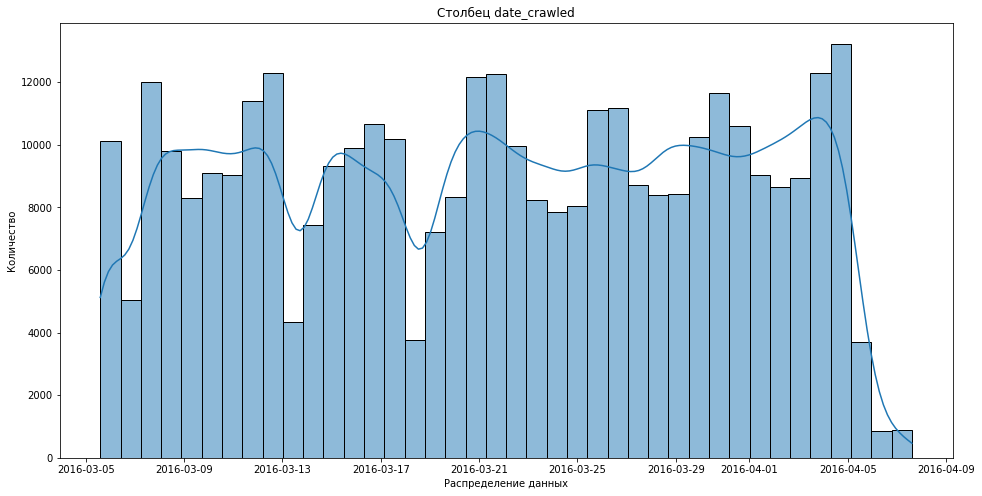

________________________________________________________________________________________________________________________


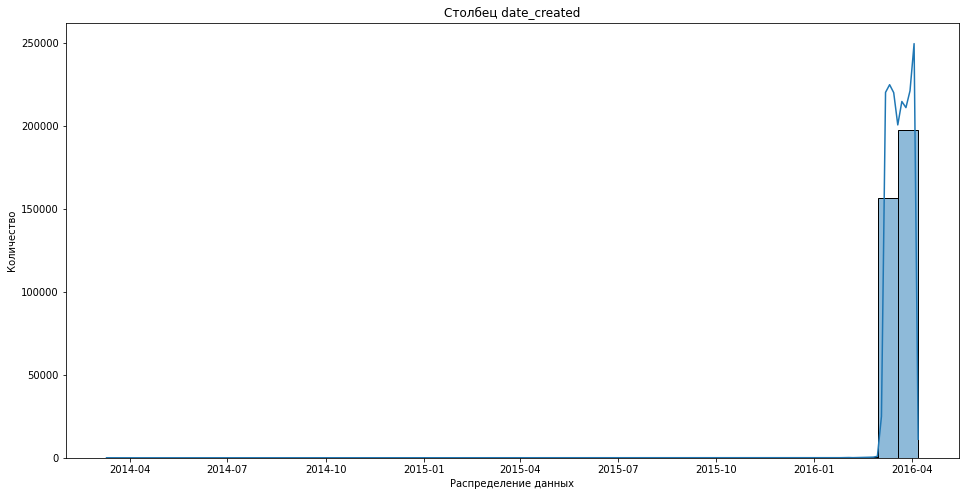

________________________________________________________________________________________________________________________


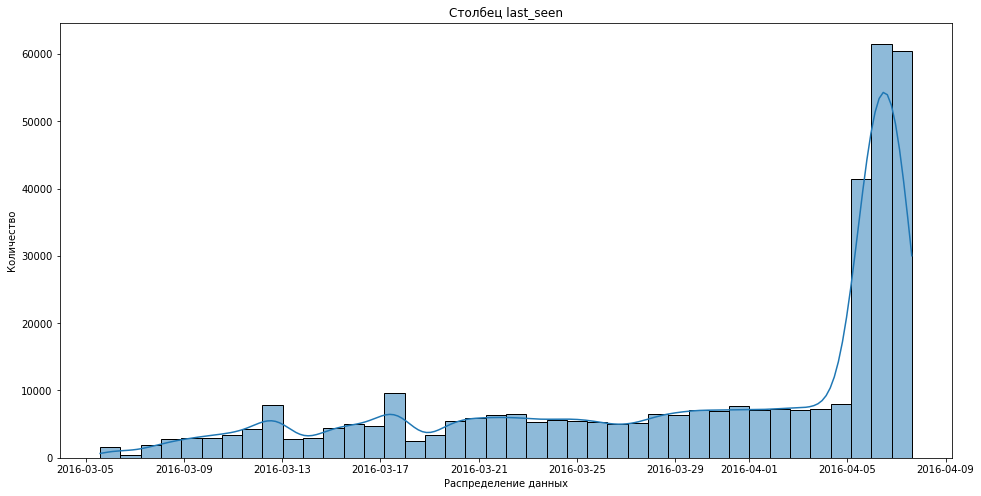

________________________________________________________________________________________________________________________


In [17]:
date = data_new.select_dtypes(include = 'datetime').columns

for column in date:
    fig, axs = plt.subplots(figsize = (16,8))
    
    sns.histplot(data = data_new[column], bins = 40, kde=True)
    plt.xlabel('Распределение данных')
    plt.ylabel('Количество')
    plt.title(f'Столбец {column}')
    
    plt.show()
    
    print('_'*120)

Из изучения столбцов с датами стало известно следующее:
- Информация о дате скачивания анкет представлена за март-апрель 2016 года.
- Большинство анкет были созданы также с марта по апрель 2016
- Такая же ситуация с датами последней активности пользователей. Пик активности приходится на начало апреля.

In [18]:
min_price = data_new.query('price <= 100').count()
registration = data_new.query('registration_year <= 1950 or registration_year > 2016').count()
power = data_new.query('power <= 25 or power > 1600').count()

print(f'Записей, где цена автомобиля меньше 1000 евро: {min_price["price"]}')
print(f'Записей, где год регистрации автомобиля меньше 1950 года или больше 2016: {registration["registration_year"]}')
print(f'Записей, где мощность автомобиля меньше 25 л.с. или больше 1600: {power["power"]}')

Записей, где цена автомобиля меньше 1000 евро: 14345
Записей, где год регистрации автомобиля меньше 1950 года или больше 2016: 14794
Записей, где мощность автомобиля меньше 25 л.с. или больше 1600: 40943


- Аномальные значения в целевом признаке удалим, чтобы модель не обучалась на ошибочных данных.
- Записей с аномальными годами регистрации не много, их тоже можно удалить.
- В столбце с мощностью автомобиля другая ситуация - записей слишком много, чтобы удалить все. Нужно посмотреть влияние этого признака на целевой.

### Устранение аномальных значений

In [19]:
print(round(data_new['price'].corr(data_new['power'], method = 'spearman'), 2))

0.51


Мощность почти не влияет на показатель цены автомобиля, поэтому удалим записи с показателем мощности больше 1600 л.с., т.к. количество таких строк равно 179. Остальные заменим на среднее значение при обработке пропусков

In [20]:
data_new = data_new.loc[data_new['price'] > 100]
data_new = data_new.query('1950 <= registration_year <= 2016')
data_new = data_new.loc[data_new['power'] <= 1600]
data_new.shape

(339646, 16)

Заменим значения мощности, которые меньше 25 л.с. на значения NaN, чтобы заменить на медиану.

In [21]:
data_new.loc[data_new['power'] <= 25, 'power'] = np.nan

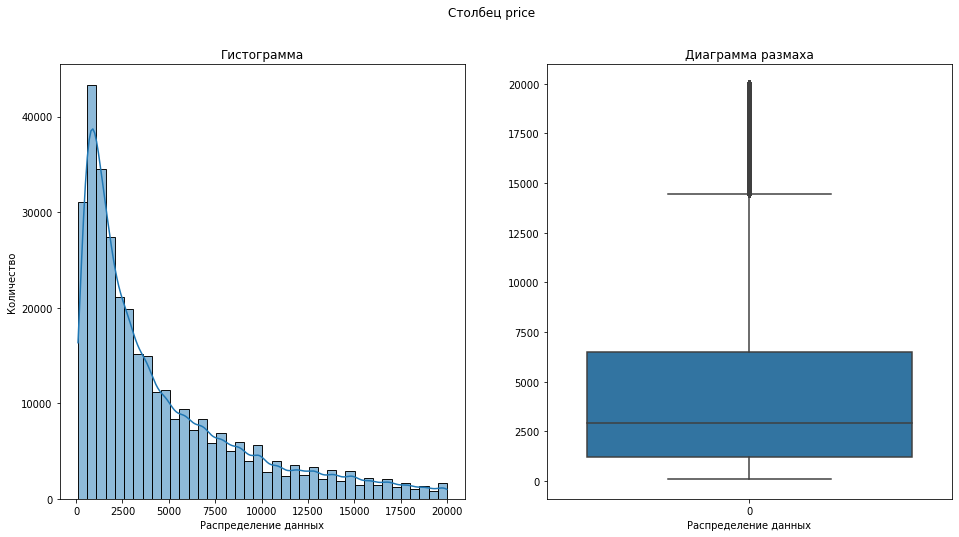

count    339646.000000
mean       4602.535493
std        4514.350640
min         101.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

________________________________________________________________________________________________________________________


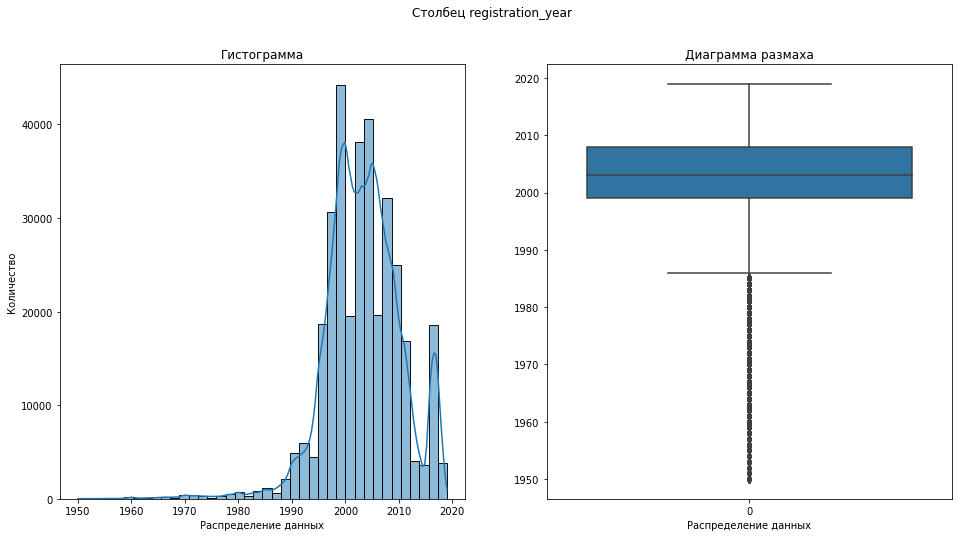

count    339646.000000
mean       2003.246674
std           7.184702
min        1950.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64

________________________________________________________________________________________________________________________


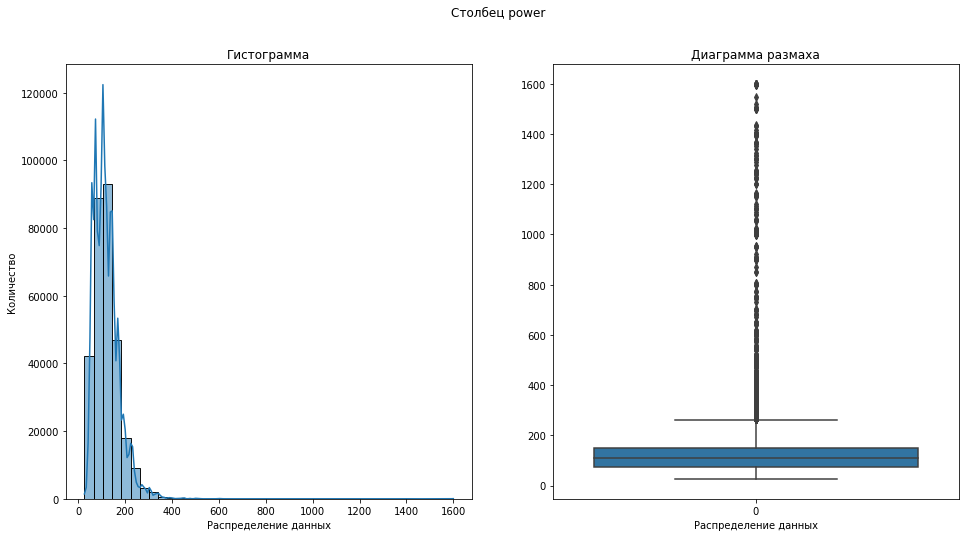

count    304640.000000
mean        121.123487
std          59.108459
min          26.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1600.000000
Name: power, dtype: float64

________________________________________________________________________________________________________________________


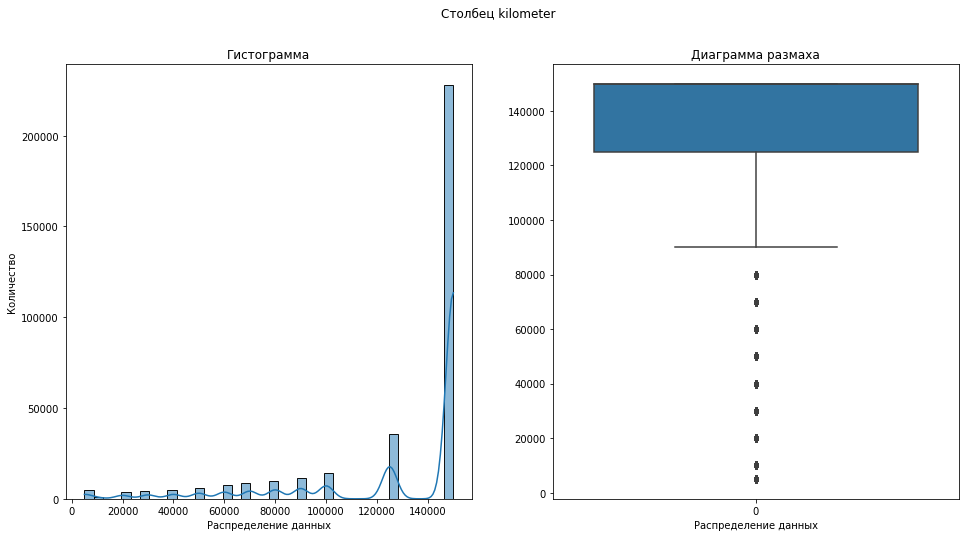

count    339646.000000
mean     128561.296173
std       37122.822942
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

________________________________________________________________________________________________________________________


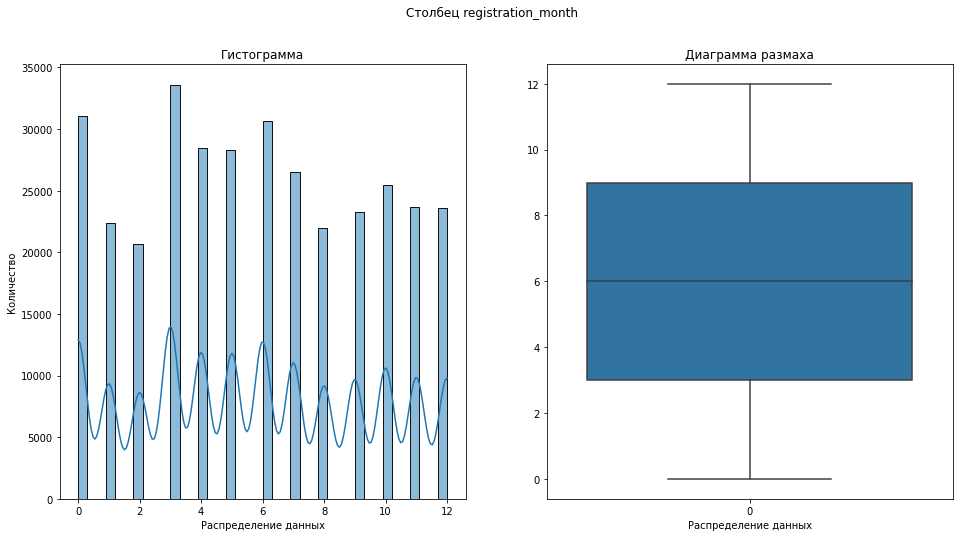

count    339646.000000
mean          5.808615
std           3.685194
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

________________________________________________________________________________________________________________________


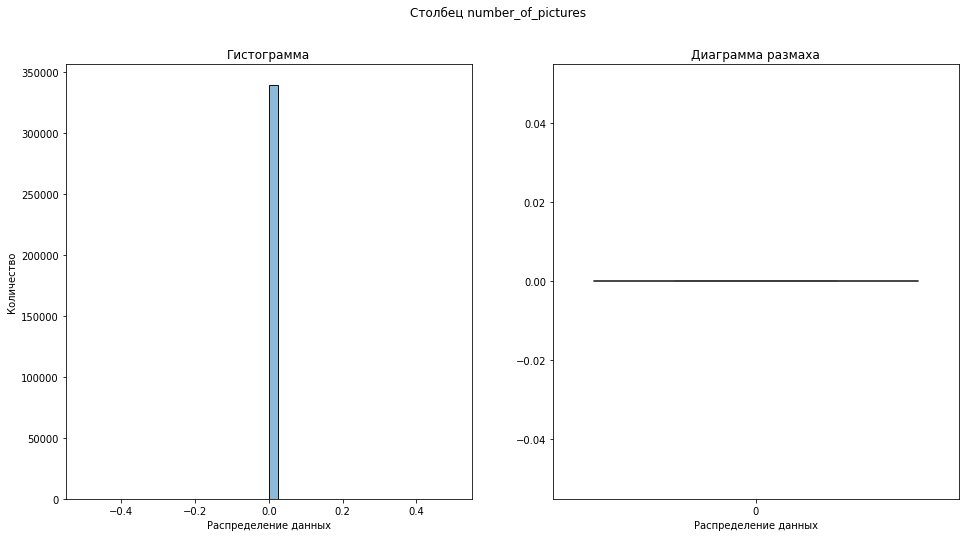

count    339646.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

________________________________________________________________________________________________________________________


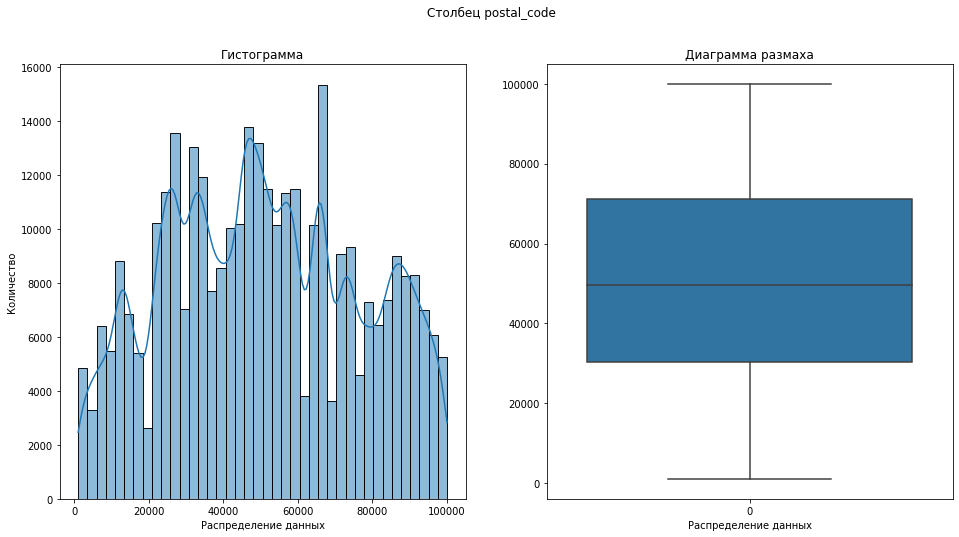

count    339646.00000
mean      50708.73427
std       25721.29739
min        1067.00000
25%       30455.00000
50%       49545.00000
75%       71229.00000
max       99998.00000
Name: postal_code, dtype: float64

________________________________________________________________________________________________________________________


In [22]:
num = data_new.select_dtypes(include = 'number').columns

for column in num:
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (16,8))
    
    sns.histplot(data = data_new[column], ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel('Распределение данных')
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')

    sns.boxplot(data = data_new[column], ax=axs[1])
    axs[1].set_xlabel('Распределение данных')
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Столбец {column}')
    
    plt.show()
    
    display(data_new[column].describe())
    print('_'*120)

После устранения аномальных значений можно сделать выводы относительно данных. Большинство машин:
- имеют цену от 1200 до 6500 евро
- были зарегестрированы в период от 1999 по 2008. Пик значений находится с 1999 на 2000 год.
- имеют мощность от 75 до 150 л.с.
- имеют пробег от 125000 до 150000 км
- было продано в 1, 3 и 6 месяцы. Основной период продажи машин с марта по июнь.
- все автомобили представлены без фотографий

### Удаление признаков

Согласно требованию заказчика стоимость автомобиля должна прогнозироваться на технические характеристиках, комплектации и ценах автомобилей. Исходя из этого можно удалить следующие признаки:
- DateCrawled — дата скачивания анкеты из базы
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

In [23]:
data_new = data_new.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis = 1)
data_new.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,NaN,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190.0,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no


### Корреляционный анализ

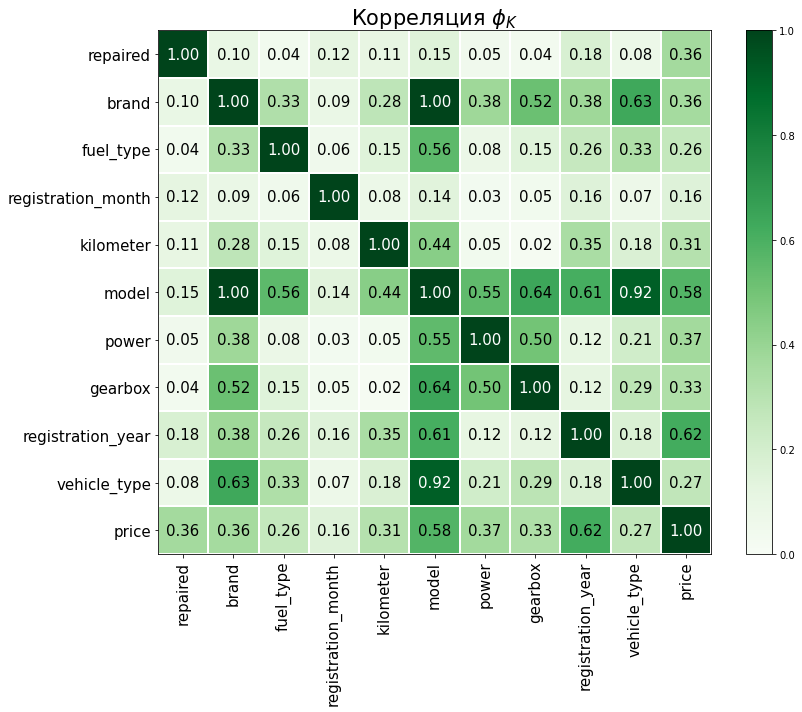

In [24]:
phik_matr = (data_new.phik_matrix(verbose=False))

plot_correlation_matrix(
    phik_matr.values,
    x_labels=phik_matr.columns,
    y_labels=phik_matr.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Корреляция $\phi_K$',
    fontsize_factor=1.5,
    figsize=(12, 10)
)

Из матрицы корреляции видно, что сильного влияния на целевой признак не оказывает ни один входной, месяц регистрации влияет на цену в средней степени, а модель в малой.

Модель напрямую вляет на бренд авктомобиля и на тип кузова.

### Обработка пропкусков

In [25]:
display(data_new.isna().sum())
print('Процент пропусков от общего количетсва')
display(round(data_new.isna().sum()/len(data_new) * 100, 0))

price                     0
vehicle_type          32091
registration_year         0
gearbox               15955
power                 35006
model                 16784
kilometer                 0
registration_month        0
fuel_type             27860
brand                     0
repaired              63661
dtype: int64

Процент пропусков от общего количетсва


price                  0.0
vehicle_type           9.0
registration_year      0.0
gearbox                5.0
power                 10.0
model                  5.0
kilometer              0.0
registration_month     0.0
fuel_type              8.0
brand                  0.0
repaired              19.0
dtype: float64

Столбцы `gearbox` и `model` содержат 5% пропущеных значений, исходя из матрицы корреляции ни один из этих признаков не влияет на целевой в сильной степени. Можно удалить пропуски в данных столбцах, т.к. без дополнительной информации заполнить их не получится.

In [26]:
data_new = data_new.dropna(subset = ['gearbox', 'model'])
display(data_new.isna().sum())
print('Процент пропусков от общего количетсва')
display(round(data_new.isna().sum()/len(data_new) * 100, 0))

price                     0
vehicle_type          21757
registration_year         0
gearbox                   0
power                 22059
model                     0
kilometer                 0
registration_month        0
fuel_type             18095
brand                     0
repaired              49265
dtype: int64

Процент пропусков от общего количетсва


price                  0.0
vehicle_type           7.0
registration_year      0.0
gearbox                0.0
power                  7.0
model                  0.0
kilometer              0.0
registration_month     0.0
fuel_type              6.0
brand                  0.0
repaired              16.0
dtype: float64

Информацию по столбцам `vehicle_type, fuel_type` восстановить также нет возможности.

In [27]:
data_new = data_new.dropna(subset = ['vehicle_type', 'fuel_type']).reset_index(drop = True)
display(data_new.isna().sum())
print('Процент пропусков от общего количетсва')
display(round(data_new.isna().sum()/len(data_new) * 100, 0))

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                 15114
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired              36146
dtype: int64

Процент пропусков от общего количетсва


price                  0.0
vehicle_type           0.0
registration_year      0.0
gearbox                0.0
power                  5.0
model                  0.0
kilometer              0.0
registration_month     0.0
fuel_type              0.0
brand                  0.0
repaired              13.0
dtype: float64

Предположим, что попуски в столбце `repaired` связаны с тем, что не указали отсутствие ремонта у машины, т.к. наличие ремонта является важными данными для покупателя.

Заполним пропуски значением 'no'

In [28]:
data_new['repaired'] = data_new['repaired'].fillna('no')
display(data_new['repaired'].value_counts())
display(data_new.isna().sum())

no     251497
yes     26032
Name: repaired, dtype: int64

price                     0
vehicle_type              0
registration_year         0
gearbox                   0
power                 15114
model                     0
kilometer                 0
registration_month        0
fuel_type                 0
brand                     0
repaired                  0
dtype: int64

Пропуски в столбце `power` заполним медианой.

In [29]:
median = data_new['power'].median()
data_new['power'] = data_new['power'].fillna(median)
display(data_new.isna().sum())

price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
dtype: int64

## Обучение моделей

Для обучения будем использовать следующие модели:
- LightGBM
- CatBoost
- LinearRegression
- DecisionTreeRegressor

Условие успешного обучения: метрика RMSE не больше 2500

### Подготовка датасетов

In [30]:
X = data_new.drop('price', axis = 1)
y = data_new['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = state
)

print(f'Размер тренировочной выборки {X_train.shape} и таргета {y_train.shape}')
print(f'Размер обучающей выборки {X_test.shape} и таргета {y_test.shape}')

Размер тренировочной выборки (208146, 10) и таргета (208146,)
Размер обучающей выборки (69383, 10) и таргета (69383,)


In [32]:
cat_col = X_train.select_dtypes(exclude = 'number').columns.tolist()
num_col = X_train.select_dtypes(include = 'number').columns.tolist()
print(cat_col)
print(num_col)

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
['registration_year', 'power', 'kilometer', 'registration_month']


In [33]:
ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = np.nan)),
        
        ('simpleImputer_after', SimpleImputer(missing_values = np.nan, strategy = 'median'))
    ])


column_prep = ColumnTransformer(
    [
        ('ord', ord_pipe, cat_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder = 'passthrough'
)
X_train_prep = pd.DataFrame(column_prep.fit_transform(X_train), columns = cat_col + num_col)
X_train_prep.head()

,vehicle_type,gearbox,model,fuel_type,brand,repaired,registration_year,power,kilometer,registration_month
0,1.0,0.0,28.0,2.0,1.0,0.0,0.865765,-0.125408,0.596232,1.671897
1,5.0,1.0,102.0,6.0,10.0,0.0,-1.085347,-1.278773,0.596232,-1.441638
2,4.0,0.0,15.0,2.0,2.0,0.0,0.052802,1.258629,0.596232,-0.592492
3,4.0,0.0,191.0,6.0,20.0,0.0,-0.597569,2.802362,-0.084157,-1.441638
4,7.0,0.0,101.0,6.0,31.0,0.0,0.215394,-0.835171,0.596232,-0.592492


### Обучение моделей

In [34]:
def fit_model(model, features, target):
    
    cross_score = cross_val_score(
        model,
        features,
        target,
        scoring = 'neg_root_mean_squared_error',
        n_jobs = -1,
        cv = 5
    ).mean()
    
    return abs(cross_score)

#### LGBMRegressor

In [35]:
lgbmr_features = X_train.select_dtypes(include = 'object').columns.tolist() 

for i in lgbmr_features:
    X_train_prep[i] = X_train_prep[i].astype('category')

In [37]:
lgbmr = LGBMRegressor(categorical_feature = lgbmr_features)

start_time = timeit.default_timer()

score_lgbmr = fit_model(lgbmr, X_train_prep, y_train)

elapsed = timeit.default_timer() - start_time

print(f'Метрика RMSE: {score_lgbmr:.2f}')
print(f'Время выполнения: {elapsed:.2f}')

Метрика RMSE: 1587.07
Время выполнения: 145.71


#### CatBoostRegressor

In [38]:
cat_features = X_train.select_dtypes(include = 'object').columns.tolist() 

for i in cat_features:
    X_train[i] = X_train[i].astype('str')

In [43]:
cbr = CatBoostRegressor(depth = 10, iterations = 50, cat_features = cat_features, verbose = 25)

start_time = timeit.default_timer()

score_cbr = fit_model(cbr, X_train, y_train)

elapsed = timeit.default_timer() - start_time

print(f'Метрика RMSE: {score_cbr:.2f}')
print(f'Время выполнения: {elapsed:.2f}')

Learning rate set to 0.5
0:	learn: 3108.1142555	total: 96.6ms	remaining: 4.73s
25:	learn: 1598.3291661	total: 2.29s	remaining: 2.11s
49:	learn: 1500.2732030	total: 4.39s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3101.6079711	total: 93.7ms	remaining: 4.59s
25:	learn: 1618.0143038	total: 2.19s	remaining: 2.02s
49:	learn: 1502.9098528	total: 4.23s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3108.7546821	total: 94.3ms	remaining: 4.62s
25:	learn: 1596.4601906	total: 2.21s	remaining: 2.04s
49:	learn: 1492.3185620	total: 4.31s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3096.2699296	total: 94.6ms	remaining: 4.63s
25:	learn: 1593.9465670	total: 2.25s	remaining: 2.08s
49:	learn: 1496.0337038	total: 4.28s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3104.8313661	total: 89.2ms	remaining: 4.37s
25:	learn: 1590.9945330	total: 2.26s	remaining: 2.09s
49:	learn: 1491.0418376	total: 4.66s	remaining: 0us
Метрика RMSE: 1604.97
Время выполнения: 26.18


#### Ridge

In [44]:
ohe_pipe = Pipeline(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

column_prep_lr = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_col),
        ('num', StandardScaler(), num_col)
    ],
    remainder = 'passthrough'
)
X_train_lr = pd.DataFrame(column_prep_lr.fit_transform(X_train))
X_train_lr.head()

,0,1,2,3,4,5,6,7,8,9,...,295,296,297,298,299,300,301,302,303,304
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.865765,-0.125408,0.596232,1.671897
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.085347,-1.278773,0.596232,-1.441638
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.052802,1.258629,0.596232,-0.592492
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.597569,2.802362,-0.084157,-1.441638
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.215394,-0.835171,0.596232,-0.592492


In [45]:
model = Ridge(random_state = state)

start_time = timeit.default_timer()

score = fit_model(model, X_train_lr, y_train)

elapsed = timeit.default_timer() - start_time

print(f'Метрика RMSE: {score:.2f}')
print(f'Время выполнения: {elapsed:.2f}')

Метрика RMSE: 2580.35
Время выполнения: 17.69


При условии, что метрика RMSE будет меньше 2500, справились модели градиентного бустинга:
- LGBMRRegressor
    - Метрика RMSE: 1668.56
    - Время общего выполнения: 44.79
- CatBoostRegressor
    - Метрика RMSE: 1604.97
    - Время общего выполнения: 25.07

Далее сравним их скорость обучения и предсказания.

## Анализ моделей

In [46]:
X_test_prep = pd.DataFrame(column_prep.transform(X_test), columns = cat_col + num_col)
for i in lgbmr_features:
    X_test_prep[i] = X_test_prep[i].astype('category')
X_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69383 entries, 0 to 69382
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   vehicle_type        69383 non-null  category
 1   gearbox             69383 non-null  category
 2   model               69383 non-null  category
 3   fuel_type           69383 non-null  category
 4   brand               69383 non-null  category
 5   repaired            69383 non-null  category
 6   registration_year   69383 non-null  float64 
 7   power               69383 non-null  float64 
 8   kilometer           69383 non-null  float64 
 9   registration_month  69383 non-null  float64 
dtypes: category(6), float64(4)
memory usage: 2.6 MB


In [47]:
for i in lgbmr_features:
    X_test_prep[i] = X_test_prep[i].astype('category')
X_test_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69383 entries, 0 to 69382
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   vehicle_type        69383 non-null  category
 1   gearbox             69383 non-null  category
 2   model               69383 non-null  category
 3   fuel_type           69383 non-null  category
 4   brand               69383 non-null  category
 5   repaired            69383 non-null  category
 6   registration_year   69383 non-null  float64 
 7   power               69383 non-null  float64 
 8   kilometer           69383 non-null  float64 
 9   registration_month  69383 non-null  float64 
dtypes: category(6), float64(4)
memory usage: 2.6 MB


### Сравнение скорости обучения и предсказания моделей

In [48]:
start_time = timeit.default_timer()
lgbmr.fit(X_train_prep, y_train)
fit_time_lgbmr = timeit.default_timer() - start_time

start_time = timeit.default_timer()
predict = lgbmr.predict(X_test_prep)
predict_time_lgbmr = timeit.default_timer() - start_time

rmse_lgbmr = mean_squared_error(y_test, predict, squared = False)

In [49]:
start_time = timeit.default_timer()
cbr.fit(X_train, y_train)
fit_time_cbr = timeit.default_timer() - start_time

start_time = timeit.default_timer()
predict = cbr.predict(X_test)
predict_time_cbr = timeit.default_timer() - start_time

rmse_cbr = mean_squared_error(y_test, predict, squared = False)

Learning rate set to 0.5
0:	learn: 3102.9196730	total: 115ms	remaining: 5.64s
25:	learn: 1609.0259779	total: 2.95s	remaining: 2.72s
49:	learn: 1515.4997569	total: 5.67s	remaining: 0us


In [50]:
time = {
    'model':['LGBMRRegressor', 'CatBoostRegressor'],
    'fit_time':[fit_time_lgbmr, fit_time_cbr],
    'predict':[predict_time_lgbmr, predict_time_cbr],
    'RMSE_on_train_data':[score_lgbmr, score_cbr],
    'RMSE_on_test_data':[rmse_lgbmr, rmse_cbr]
}
time = pd.DataFrame(time)
num = time.select_dtypes(include = 'number').columns

for i in num:
    time[i] = round(time[i], 2)
    
time

,model,fit_time,predict,RMSE_on_train_data,RMSE_on_test_data
0,LGBMRRegressor,26.51,0.79,1587.07,1569.76
1,CatBoostRegressor,6.63,0.11,1604.97,1597.27


# Вывод

- По качеству предсказания лучше себя показала LGBMRRegressor.
- По скорости предсказания и времени обучения CatBoostRegressor.

Линейная модель Ridge имеет высокие показатели метрики, поэтому в таблицу сравнения времени она не попала, т.к. не выполняет первичного условия. Остальные модели прошли условие - метрика RMSE меньше 2500. 

**Заказчику выгоднее выбрать модель CatBoostRegressor, т.к. данная модель удовлетворяет все условия и имеет приемущества в скорости обучения и предсказания.**